In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import time
import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
import scipy
from scipy.stats import median_abs_deviation
from scipy.stats import pearsonr


sc.settings.verbosity = 2
sc.logging.print_header()

scanpy==1.10.4 anndata==0.11.4 umap==0.5.7 numpy==1.26.4 scipy==1.15.2 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.6 pynndescent==0.5.13


# Load in the data

In [2]:
path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/raw_merged_gene_data.h5ad"

adata_raw = sc.read_h5ad(path)
print(f"Initial shape: {adata_raw.shape}\n")
print(f"N cells in HYB dataset: {adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs}")
print(f"N cells in scFib dataset: {adata_raw[adata_raw.obs['dataset'] == 'Control'].n_obs}\n")

adata_raw

Initial shape: (19858, 28702)

N cells in HYB dataset: 10895
N cells in scFib dataset: 8963



AnnData object with n_obs × n_vars = 19858 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

In [4]:
adata_raw.var['gene_type'].value_counts()

gene_type
protein_coding     17023
lncRNA             11640
TR_V_gene             15
IG_V_pseudogene        7
IG_V_gene              4
TR_C_gene              3
TR_V_pseudogene        3
IG_C_pseudogene        2
IG_C_gene              2
TR_J_gene              2
TR_D_gene              1
Name: count, dtype: int64

In [3]:
### --- Handle HYB cells with NaN feature barcode predictions ---
init_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs

# remove HYB cells with NaN feature barcode predictions
hybrid_to_remove = (adata_raw.obs['dataset'] == 'Hybrid') & (adata_raw.obs['assigned_condition'].isna())
cells_to_keep = ~(hybrid_to_remove)
adata_raw = adata_raw[cells_to_keep].copy()

final_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs
removed_hybrid_cells = init_cells_hybrid - final_cells_hybrid

print(f"Removed {removed_hybrid_cells} 'Hybrid' cells with unassigned feature barcodes")
print(f"Final shape: {adata_raw.shape}")


### --- Add new column for grouping HYB cells vs Controls ---
adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({
    "G1": "Control",
    "S": "Control",
    "G2M": "Control",
    "PRRX1": "siPRRX1",
    "PRRX1_MYOD": "siPRRX1/mmMYOD1",
    "MYOD": "mmMYOD1"
})

# fill remaining NaN feature barcode predictions (only control cells) with 'Control'
adata_raw.obs['pooled_condition'] = adata_raw.obs['pooled_condition'].fillna('Control')
print(adata_raw.obs['pooled_condition'].value_counts())

adata_raw

Removed 1 'Hybrid' cells with unassigned feature barcodes
Final shape: (19857, 28702)
pooled_condition
Control            8963
siPRRX1/mmMYOD1    4174
siPRRX1            3955
mmMYOD1            2765
Name: count, dtype: int64


/tmp/ipykernel_3494978/1807916870.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({


AnnData object with n_obs × n_vars = 19857 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

# QC (by dataset)

In [20]:
# hyb_adata = adata_raw[adata_raw.obs['dataset'] == 'Hybrid']
# print(f"HYB shape: {hyb_adata.shape}")
# fib_adata = adata_raw[adata_raw.obs['dataset'] == 'Control']
# print(f"scFib shape: {fib_adata.shape}")

HYB shape: (10894, 28702)
scFib shape: (8963, 28702)


HYBRID:



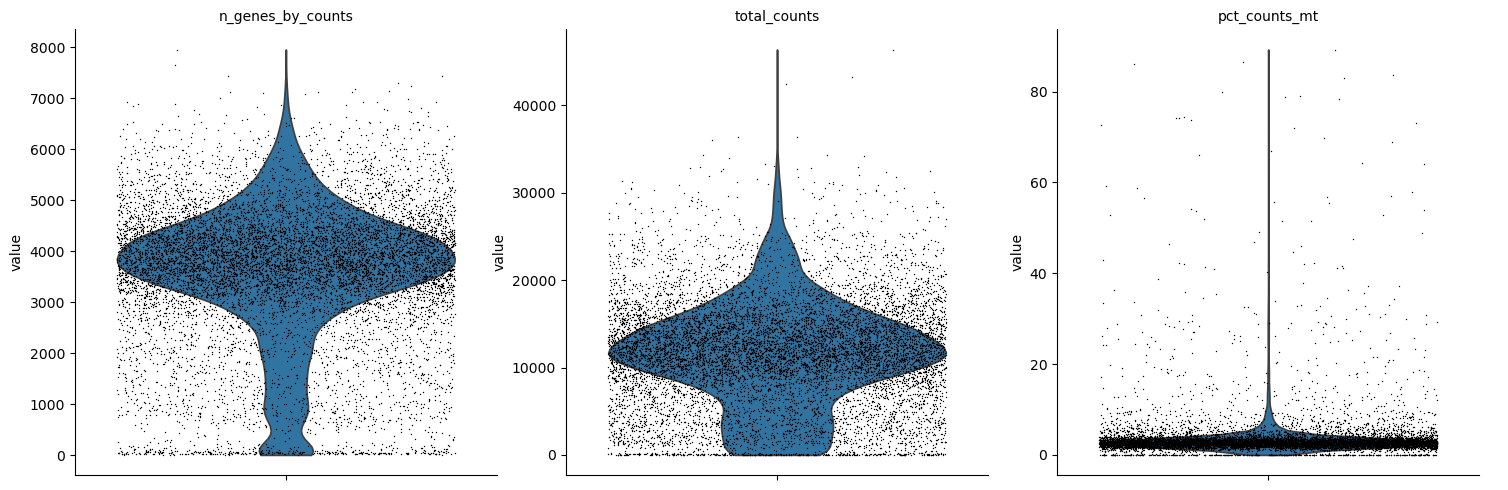

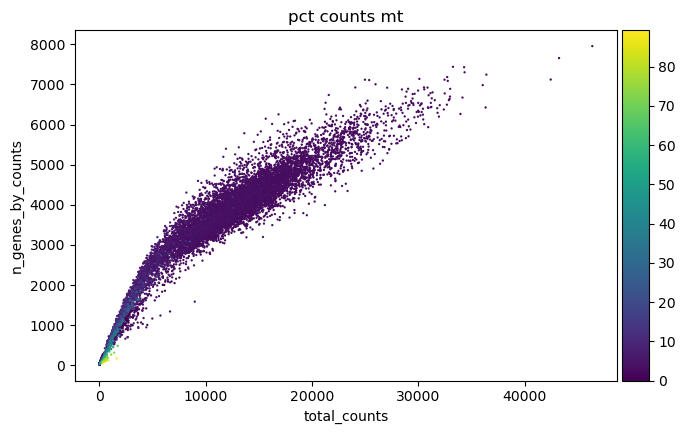

scFIB:



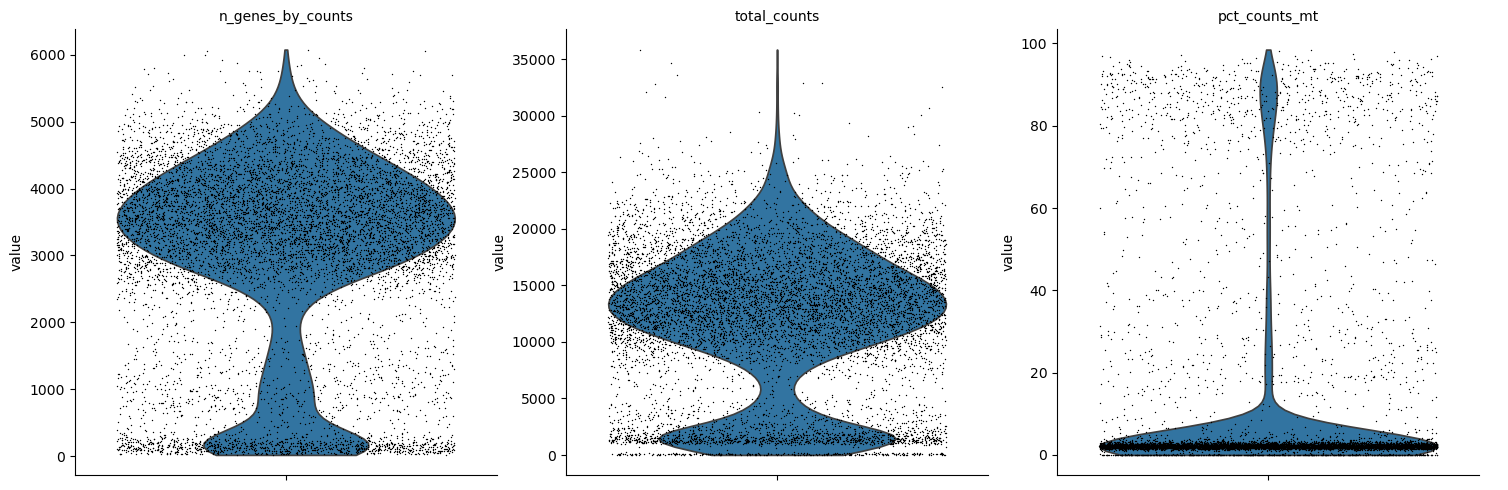

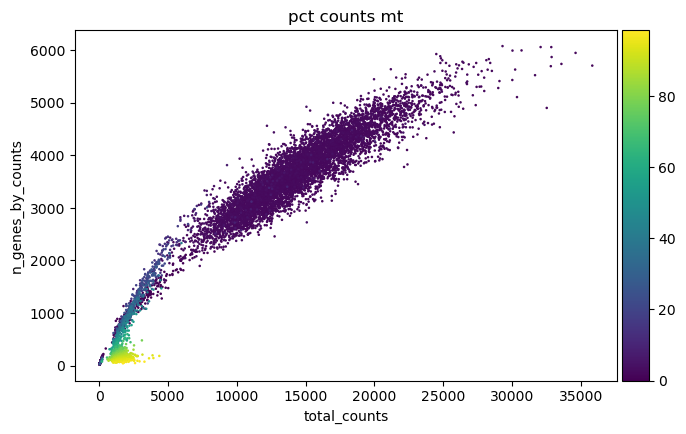

In [21]:
# ### HYB
# # mitochondrial genes
# hyb_adata.var["mt"] = hyb_adata.var_names.str.startswith("MT-")
# # ribosomal genes
# hyb_adata.var["ribo"] = hyb_adata.var_names.str.startswith(("RPS", "RPL"))

# sc.pp.calculate_qc_metrics(hyb_adata, qc_vars=["mt", "ribo"], 
#                            inplace=True, log1p=True, percent_top=[20])

# ### scFib
# fib_adata.var["mt"] = fib_adata.var_names.str.startswith("MT-")
# # ribosomal genes
# fib_adata.var["ribo"] = fib_adata.var_names.str.startswith(("RPS", "RPL"))

# sc.pp.calculate_qc_metrics(fib_adata, qc_vars=["mt", "ribo"], 
#                            inplace=True, log1p=True, percent_top=[20])


# plt.rcdefaults()

# print(f"HYBRID:\n")

# sc.pl.violin(
#     hyb_adata,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

# sc.pl.scatter(hyb_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# print(f"scFIB:\n")

# sc.pl.violin(
#     fib_adata,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

# sc.pl.scatter(fib_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Identify low quality cells with MADs

In [28]:
# def is_outlier(adata, metric: str, nmads: int):
#     M = adata.obs[metric]
#     outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
#         np.median(M) + nmads * median_abs_deviation(M) < M
#     )
#     return outlier

# n_mads = 5

# hyb_adata.obs["outlier"] = (
#     is_outlier(hyb_adata, "log1p_total_counts", n_mads)
#     | is_outlier(hyb_adata, "log1p_n_genes_by_counts", n_mads)
#     # | is_outlier(hyb_adata, "pct_counts_in_top_20_genes", 5)
# )

# hyb_adata.obs.outlier.value_counts()

outlier
False    9710
True     1184
Name: count, dtype: int64

In [29]:
# hyb_adata.obs["mt_outlier"] = is_outlier(hyb_adata, "pct_counts_mt", 3) | (
#     hyb_adata.obs["pct_counts_mt"] > 8
# )
# hyb_adata.obs.mt_outlier.value_counts()

mt_outlier
False    9222
True     1672
Name: count, dtype: int64

Lower MAD threshold for log1p_total_counts: 7.97
Upper MAD threshold for log1p_total_counts: 10.77


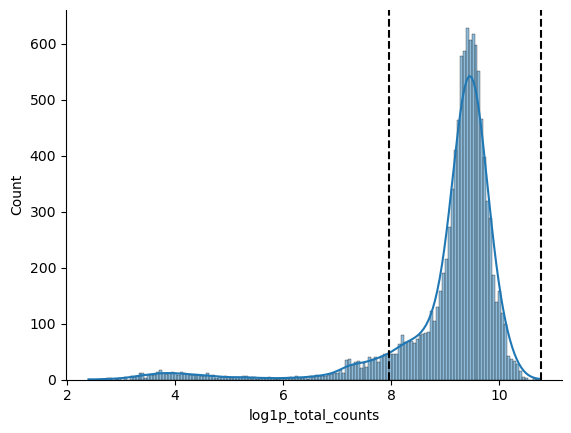

In [25]:
# def is_outlier_thresholds(adata, metric: str, nmads: int):
#     M = adata.obs[metric]
#     median_val = np.median(M)
#     mad_val = median_abs_deviation(M)
#     lower_threshold = median_val - nmads * mad_val
#     upper_threshold = median_val + nmads * mad_val
#     return lower_threshold, upper_threshold

# lower_bound, upper_bound = is_outlier_thresholds(hyb_adata, 'log1p_total_counts', n_mads)

# print(f"Lower MAD threshold for log1p_total_counts: {lower_bound:.2f}")
# print(f"Upper MAD threshold for log1p_total_counts: {upper_bound:.2f}")

# sns.histplot(
#     hyb_adata.obs,
#     x=hyb_adata.obs['log1p_total_counts'],
#     kde=True,
# )

# plt.axvline(x=lower_bound, color='k', linestyle='--')
# plt.axvline(x=upper_bound, color='k', linestyle='--')

# sns.despine()

Lower MAD threshold for log1p_n_genes_by_counts: 7.45
Upper MAD threshold for log1p_n_genes_by_counts: 9.02


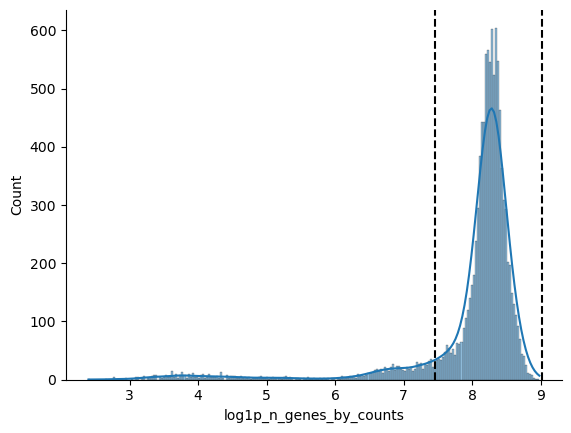

In [26]:
# lower_bound, upper_bound = is_outlier_thresholds(hyb_adata, 'log1p_n_genes_by_counts', n_mads)

# print(f"Lower MAD threshold for log1p_n_genes_by_counts: {lower_bound:.2f}")
# print(f"Upper MAD threshold for log1p_n_genes_by_counts: {upper_bound:.2f}")

# sns.histplot(
#     hyb_adata.obs,
#     x=hyb_adata.obs['log1p_n_genes_by_counts'],
#     kde=True,
# )

# plt.axvline(x=lower_bound, color='k', linestyle='--')
# plt.axvline(x=upper_bound, color='k', linestyle='--')

# sns.despine()

Lower MAD threshold for pct_counts_mt: 0.85
Upper MAD threshold for pct_counts_mt: 4.57


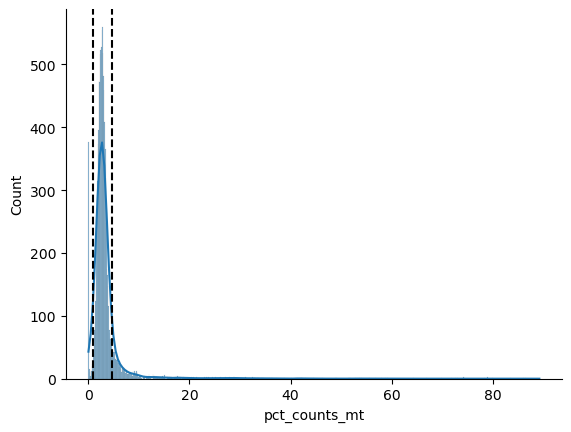

In [27]:
# lower_bound, upper_bound = is_outlier_thresholds(hyb_adata, 'pct_counts_mt', 3)

# print(f"Lower MAD threshold for pct_counts_mt: {lower_bound:.2f}")
# print(f"Upper MAD threshold for pct_counts_mt: {upper_bound:.2f}")

# sns.histplot(
#     hyb_adata.obs,
#     x=hyb_adata.obs['pct_counts_mt'],
#     kde=True,
# )

# plt.axvline(x=lower_bound, color='k', linestyle='--')
# plt.axvline(x=upper_bound, color='k', linestyle='--')

# sns.despine()

In [15]:
# fib_adata.obs["outlier"] = (
#     is_outlier(fib_adata, "log1p_total_counts", 5)
#     | is_outlier(fib_adata, "log1p_n_genes_by_counts", 5)
#     # | is_outlier(fib_adata, "pct_counts_in_top_20_genes", 5)
# )

# fib_adata.obs.outlier.value_counts()

outlier
False    7287
True     1676
Name: count, dtype: int64

In [16]:
# fib_adata.obs["mt_outlier"] = is_outlier(fib_adata, "pct_counts_mt", 3) | (
#     fib_adata.obs["pct_counts_mt"] > 8
# )
# fib_adata.obs.mt_outlier.value_counts()

mt_outlier
False    6921
True     2042
Name: count, dtype: int64

In [30]:
# print(f"Total number of cells: {hyb_adata.n_obs}")
# init_cells = hyb_adata.n_obs

# hyb_adata = hyb_adata[(~hyb_adata.obs.outlier) & (~hyb_adata.obs.mt_outlier)].copy()
# final_cells = hyb_adata.n_obs

# print(f"Removed {init_cells - final_cells}")
# print(f"Number of cells after filtering of low quality cells: {hyb_adata.n_obs}")

Total number of cells: 10894
Removed 1887
Number of cells after filtering of low quality cells: 9007


In [31]:
# hyb_adata.obs['assigned_condition'].value_counts()

assigned_condition
PRRX1         3638
PRRX1_MYOD    3308
MYOD          2061
Name: count, dtype: int64

In [34]:
# pearson_corr, pearson_p_value = pearsonr(hyb_adata.obs['total_counts'], hyb_adata.obs['pct_counts_mt'])

# print(f"Pearson Correlation (total_counts vs. pct_counts_mt): {pearson_corr:.4f}")
# print(f"P-value: {pearson_p_value:.4e}") 

# pearson_corr, pearson_p_value = pearsonr(hyb_adata.obs['total_counts'], hyb_adata.obs['n_genes_by_counts'])

# print(f"\nPearson Correlation (total_counts vs. n_genes_by_counts): {pearson_corr:.4f}")
# print(f"P-value: {pearson_p_value:.4e}") 

Pearson Correlation (total_counts vs. pct_counts_mt): -0.2628
P-value: 3.7129e-142

Pearson Correlation (total_counts vs. n_genes_by_counts): 0.9202
P-value: 0.0000e+00


In [18]:
# print(f"Total number of cells: {fib_adata.n_obs}")
# init_cells = fib_adata.n_obs

# fib_adata = fib_adata[(~fib_adata.obs.outlier) & (~fib_adata.obs.mt_outlier)].copy()
# final_cells = fib_adata.n_obs

# print(f"Removed {init_cells - final_cells}")
# print(f"Number of cells after filtering of low quality cells: {fib_adata.n_obs}")

Total number of cells: 8963
Removed 2137
Number of cells after filtering of low quality cells: 6826


# QC (combined)

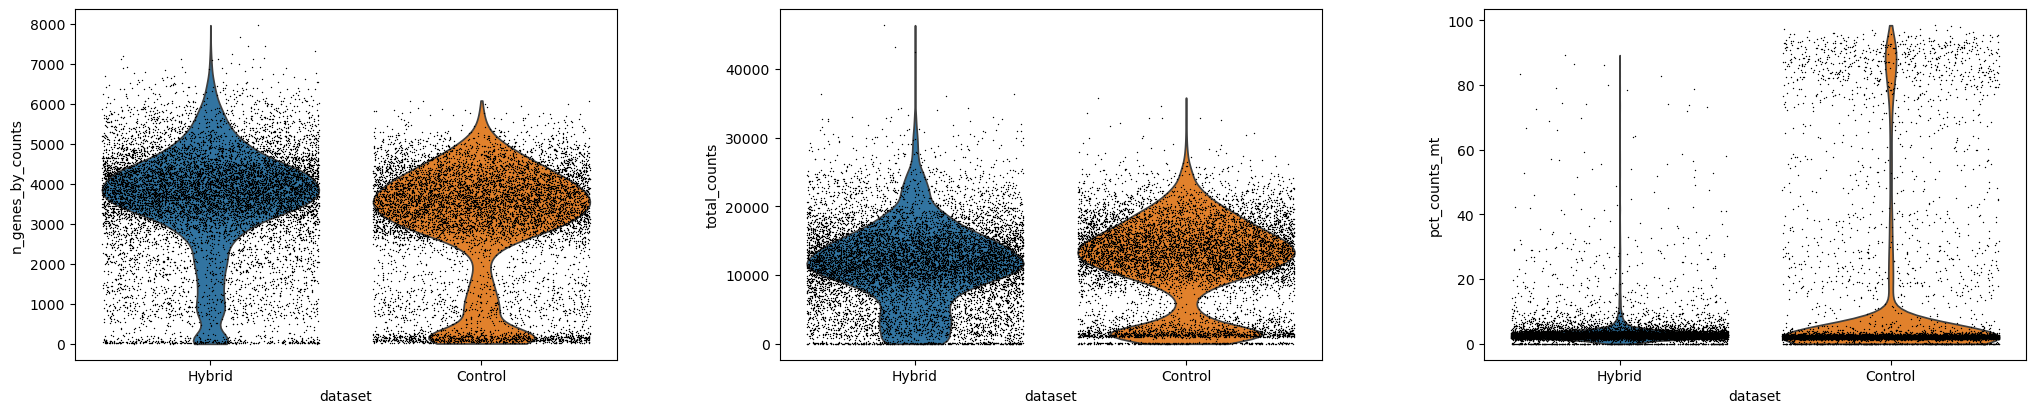

In [4]:
adata = adata_raw.copy()

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)

plt.rcdefaults()
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby='dataset',
)

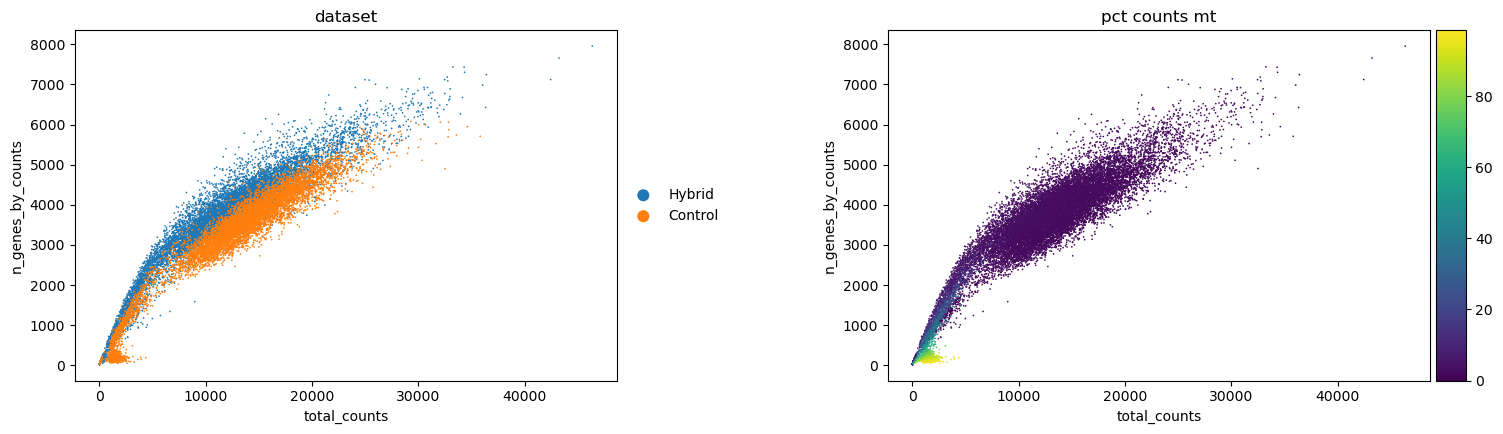

In [24]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color=["dataset", "pct_counts_mt"])

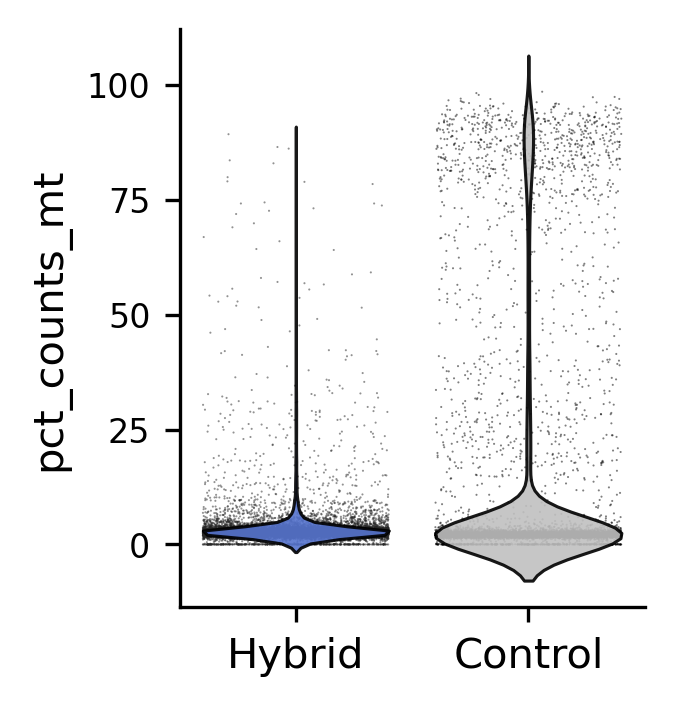

In [89]:
metric = 'n_genes_by_counts'
metric = 'total_counts'
metric = 'pct_counts_mt'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

ax = sns.violinplot(
    data=adata.obs,
    x='dataset',
    y=metric,
    hue='dataset',
    linewidth=0.75,
    linecolor='k',
    palette=dataset_colors,
    inner=None,
    alpha=0.9,
    zorder=1,
)

sns.stripplot(
    data=adata.obs,
    x='dataset',
    y=metric,
    hue='dataset',
    jitter=0.4, 
    palette='dark:black',
    edgecolor=None,
    size=0.5,       
    alpha=0.5,    
    ax=ax,        
    legend=False,
    zorder=0,
)

plt.xlabel("")
plt.yticks(fontsize=8)
sns.despine()
plt.show()

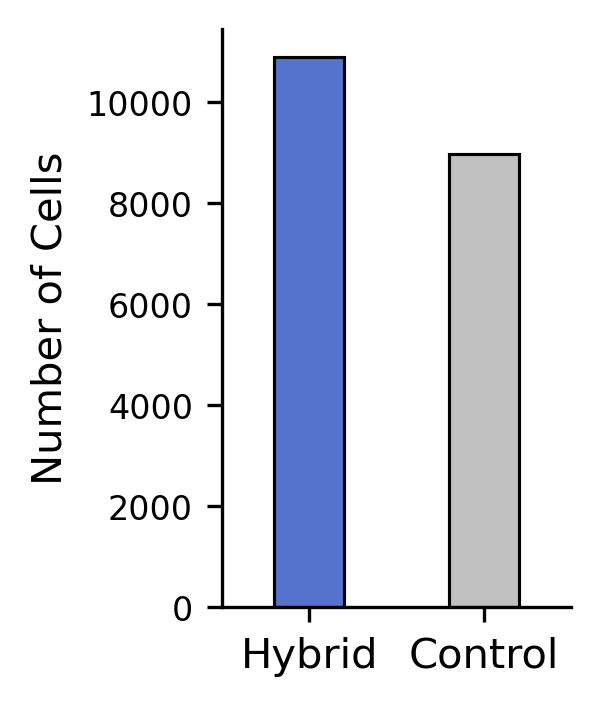

In [94]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

sns.countplot(data=adata.obs,
            x='dataset',
            hue='dataset',
            width=0.4,
            ec='k',
            linewidth=0.75,
            palette=dataset_colors,
           )

plt.ylabel("Number of Cells")
plt.xlabel("")

# plt.title("Total Cells", pad=10)

plt.yticks(fontsize=8)

sns.despine()
plt.show()

In [25]:
# Identify outlier cells with MADs per dataset
def is_outlier_by_group(adata, metric: str, nmads: int, group_col: str = 'dataset'):
    outlier_series = pd.Series(False, index=adata.obs.index)
    unique_groups = adata.obs[group_col].unique()

    for group in unique_groups:
        group_mask = (adata.obs[group_col] == group)
        M_group = adata.obs.loc[group_mask, metric]

        if len(M_group) < 2 or M_group.isnull().all():
            continue

        median_val_group = np.median(M_group)
        mad_val_group = median_abs_deviation(M_group)

        if mad_val_group == 0:
            continue

        outliers_in_group = (M_group < median_val_group - nmads * mad_val_group) | \
                            (median_val_group + nmads * mad_val_group < M_group)

        outlier_series.loc[group_mask] = outliers_in_group

    return outlier_series


adata.obs["outlier"] = (
    is_outlier_by_group(adata, "log1p_total_counts", 5, 'dataset')
    | is_outlier_by_group(adata, "log1p_n_genes_by_counts", 5, 'dataset')
)

print("Number of outlier cells per dataset based on counts:")
print(adata.obs.groupby('dataset', observed=True)['outlier'].sum())


adata.obs["mt_outlier"] = is_outlier_by_group(adata, "pct_counts_mt", 5, 'dataset') | (
    adata.obs["pct_counts_mt"] > 20
)

print("\nNumber of outlier cells per dataset based on pct mito:")
adata.obs.groupby('dataset', observed=True)['mt_outlier'].sum()

Number of outlier cells per dataset based on counts:
dataset
Hybrid     1184
Control    1676
Name: outlier, dtype: int64

Number of outlier cells per dataset based on pct mito:


dataset
Hybrid      788
Control    1852
Name: mt_outlier, dtype: int64

In [26]:
init_cells = adata.n_obs
init_cells_hyb = adata[adata.obs['dataset'] == 'Hybrid'].n_obs
init_cells_fib = adata[adata.obs['dataset'] == 'Control'].n_obs

print(f"Total number of cells: {init_cells}")
print(f"N cells in Hybird: {init_cells_hyb}")
print(f"N cells in Control: {init_cells_fib}")

print(f"\nFiltering...")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

final_cells = adata.n_obs
final_cells_hyb = adata[adata.obs['dataset'] == 'Hybrid'].n_obs
final_cells_fib = adata[adata.obs['dataset'] == 'Control'].n_obs


print(f"\nRemoved {init_cells - final_cells} total cells.")
print(f"Removed {init_cells_hyb - final_cells_hyb} from Hybrid dataset.")
print(f"Removed {init_cells_fib - final_cells_fib} from Control dataset.")


print(f"\nTotal cells after filtering of low quality cells: {final_cells}")
print(f"N cells in Hybird: {final_cells_hyb}")
print(f"N cells in Control: {final_cells_fib}")

Total number of cells: 19857
N cells in Hybird: 10894
N cells in Control: 8963

Filtering...

Removed 3490 total cells.
Removed 1487 from Hybrid dataset.
Removed 2003 from Control dataset.

Total cells after filtering of low quality cells: 16367
N cells in Hybird: 9407
N cells in Control: 6960


In [27]:
print(f"GROUPED:")
corr, pval = pearsonr(adata.obs['total_counts'], adata.obs['pct_counts_mt'])

print(f"Pearson Correlation (total_counts vs. pct_counts_mt): {corr:.4f}")
print(f"P-value: {pval:.4e}") 


corr, pval = pearsonr(adata.obs['total_counts'], adata.obs['n_genes_by_counts'])

print(f"\nPearson Correlation (total_counts vs. n_genes_by_counts): {corr:.4f}")
print(f"P-value: {pval:.4e}") 


print(f"\nSEPARATE:")

corr_df = adata.obs[['dataset', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt']].copy()

corr_by_dataset = corr_df.groupby('dataset', observed=True).corr()
corr_by_dataset

GROUPED:
Pearson Correlation (total_counts vs. pct_counts_mt): -0.3357
P-value: 0.0000e+00

Pearson Correlation (total_counts vs. n_genes_by_counts): 0.8652
P-value: 0.0000e+00

SEPARATE:


total_counts  n_genes_by_counts  pct_counts_mt
dataset                                                                  
Hybrid  total_counts           1.000000           0.924146      -0.348091
        n_genes_by_counts      0.924146           1.000000      -0.301153
        pct_counts_mt         -0.348091          -0.301153       1.000000
Control total_counts           1.000000           0.919580      -0.168964
        n_genes_by_counts      0.919580           1.000000      -0.052543
        pct_counts_mt         -0.168964          -0.052543       1.000000

# QC and Filtering

In [28]:
# adata = adata_raw.copy()

# # mitochondrial genes
# adata.var["mt"] = adata.var_names.str.startswith("MT-")
# # ribosomal genes
# adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)


# adata.raw = adata  # keep full dimension safe
adata.layers['raw_counts'] = adata.X.copy()

print("Filtering...\n")

# adata = adata[adata.obs.pct_counts_mt < 20]
# sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_counts=10)

# sc.pp.filter_cells(adata, min_genes=500)
# sc.pp.filter_genes(adata, min_cells=10)

print("\nNormalizing counts...\n")
sc.pp.normalize_total(
    adata,
    target_sum=1e4,
    # exclude_highly_expressed=True, 
)

adata.layers['norm_counts'] = adata.X.copy()

sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

print(adata)

print(adata.obs['dataset'].value_counts())
adata.obs['pooled_condition'].value_counts()

Filtering...

filtered out 3576 genes that are detected in less than 10 counts

Normalizing counts...

normalizing counts per cell
    finished (0:00:00)
AnnData object with n_obs × n_vars = 16367 × 25126
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_c

pooled_condition
Control            6960
siPRRX1            3689
siPRRX1/mmMYOD1    3462
mmMYOD1            2256
Name: count, dtype: int64

# HVGs

extracting highly variable genes
    finished (0:00:03)
Number of HVG: 2000


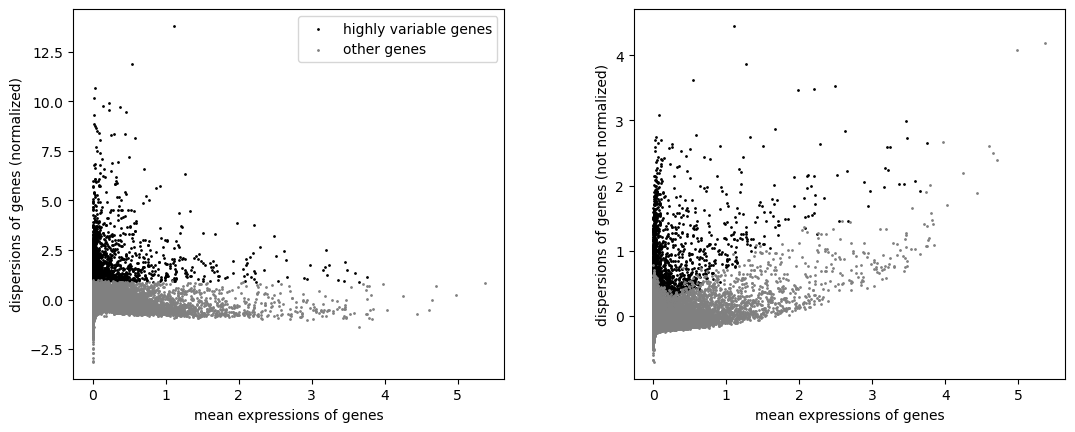

In [29]:
adata.X = adata.layers['log_norm']

sc.pp.highly_variable_genes(
    adata,
    batch_key='dataset',
    n_top_genes=2000, 
)

print(f"Number of HVG: {adata.var['highly_variable'].sum()}")

plt.rcdefaults()

sc.pl.highly_variable_genes(adata)

# PCA

computing PCA
    with n_comps=50
    finished (0:00:02)


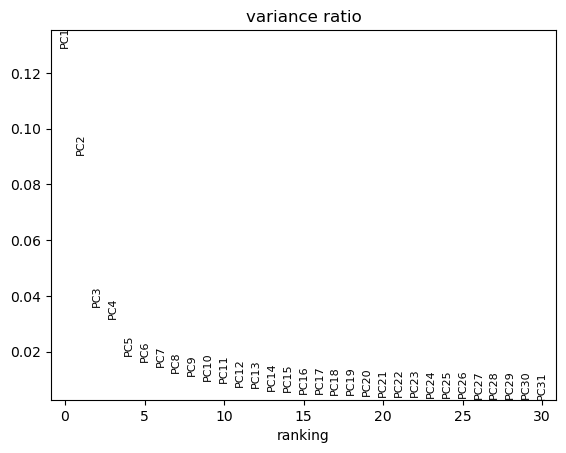

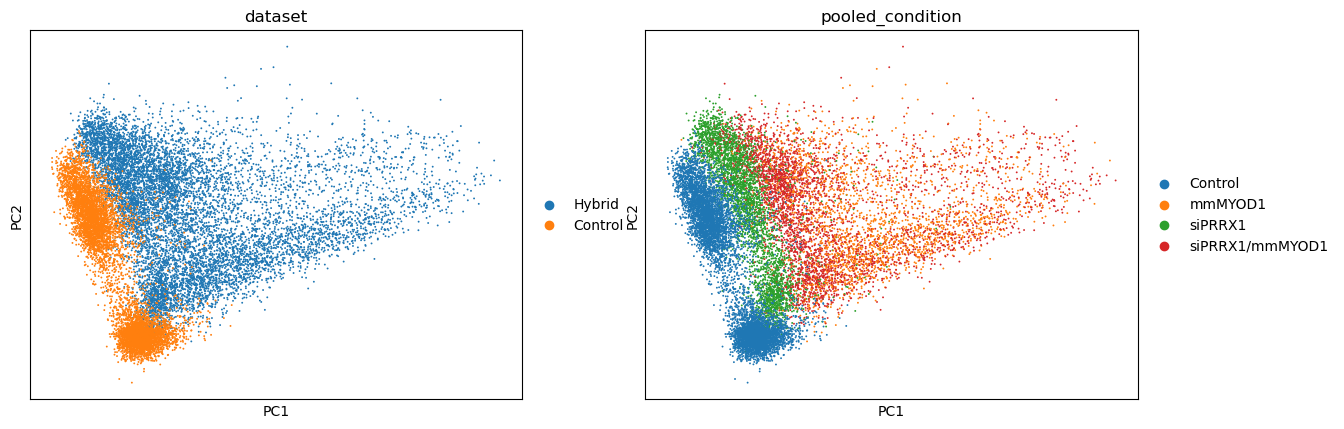

AnnData object with n_obs × n_vars = 16367 × 25126
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'da

In [30]:
sc.pp.pca(adata)

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color=['dataset', 'pooled_condition'])

adata

# Harmony integration

2025-06-02 13:45:48,724 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Mon Jun  2 13:45:48 2025 INFO Computing initial centroids with sklearn.KMeans...
2025-06-02 13:45:52,152 - harmonypy - INFO - sklearn.KMeans initialization complete.
Mon Jun  2 13:45:52 2025 INFO sklearn.KMeans initialization complete.
2025-06-02 13:45:52,234 - harmonypy - INFO - Iteration 1 of 10
Mon Jun  2 13:45:52 2025 INFO Iteration 1 of 10
2025-06-02 13:45:56,773 - harmonypy - INFO - Iteration 2 of 10
Mon Jun  2 13:45:56 2025 INFO Iteration 2 of 10
2025-06-02 13:46:01,286 - harmonypy - INFO - Converged after 2 iterations
Mon Jun  2 13:46:01 2025 INFO Converged after 2 iterations


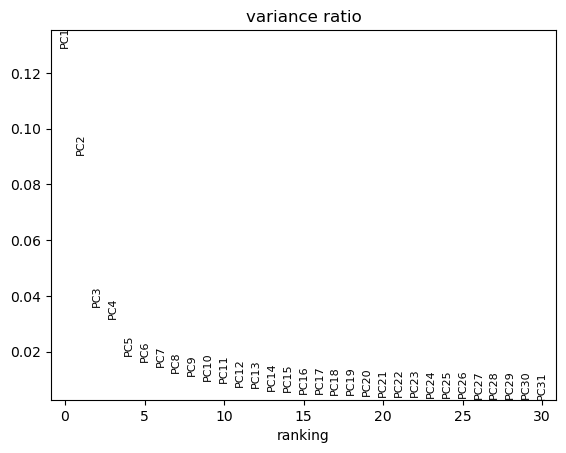

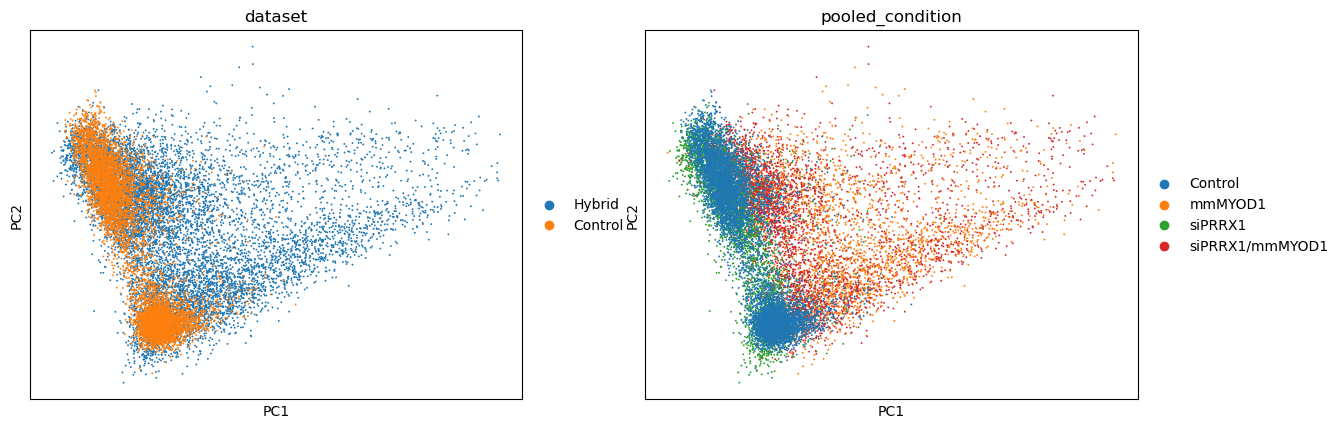

In [31]:
sce.pp.harmony_integrate(adata, 'dataset')

# Save original PCA space
adata.obsm["X_pca_original"] = adata.obsm["X_pca"].copy()

# Set Harmony-corrected PCA as the default for plotting and MAGIC imputation
adata.obsm["X_pca"] = adata.obsm["X_pca_harmony"].copy()

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color=['dataset', 'pooled_condition'])

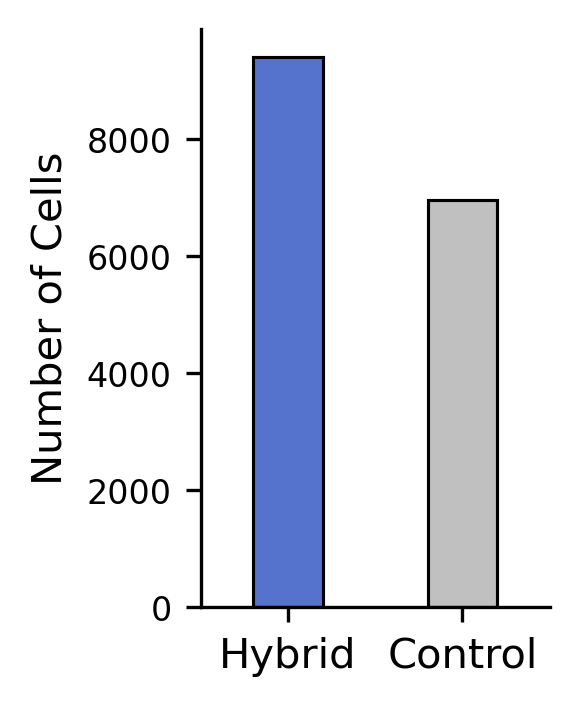

In [32]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

sns.countplot(data=adata.obs,
            x='dataset',
            hue='dataset',
            width=0.4,
            ec='k',
            linewidth=0.75,
            palette=dataset_colors,
           )

plt.ylabel("Number of Cells")
plt.xlabel("")

plt.yticks(fontsize=8)

sns.despine()
plt.show()

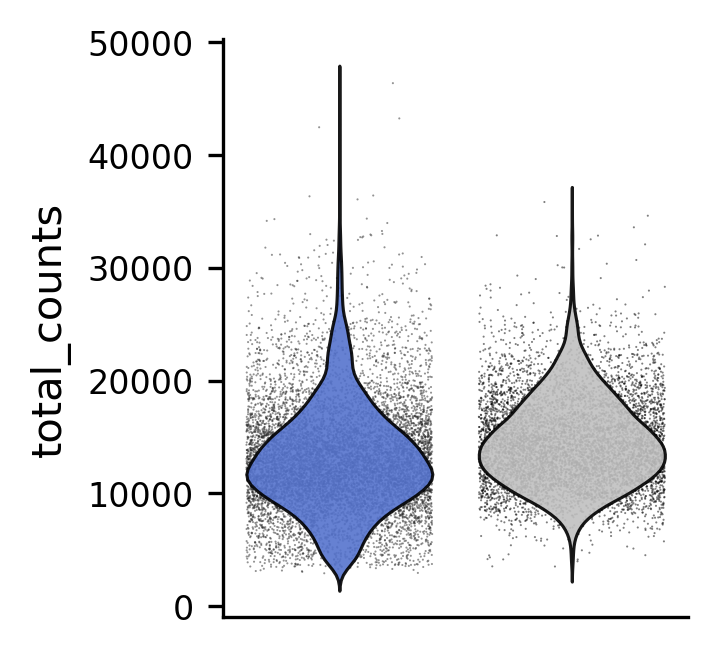

In [33]:
metric = 'n_genes_by_counts'
metric = 'total_counts'
# metric = 'pct_counts_mt'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5
fig, axs = plt.subplots()

dataset_colors = ["royalblue", "silver"]

ax = sns.violinplot(
    data=adata.obs,
    x='dataset',
    y=metric,
    hue='dataset',
    linewidth=0.75,
    linecolor='k',
    palette=dataset_colors,
    inner=None,
    alpha=0.9,
    zorder=1,
)

sns.stripplot(
    data=adata.obs,
    x='dataset',
    y=metric,
    hue='dataset',
    jitter=0.4, 
    palette='dark:black',
    edgecolor=None,
    size=0.5,       
    alpha=0.5,    
    ax=ax,        
    legend=False,
    zorder=0,
)

plt.xlabel("")
plt.xticks([])
plt.yticks(fontsize=8)
sns.despine()
plt.show()

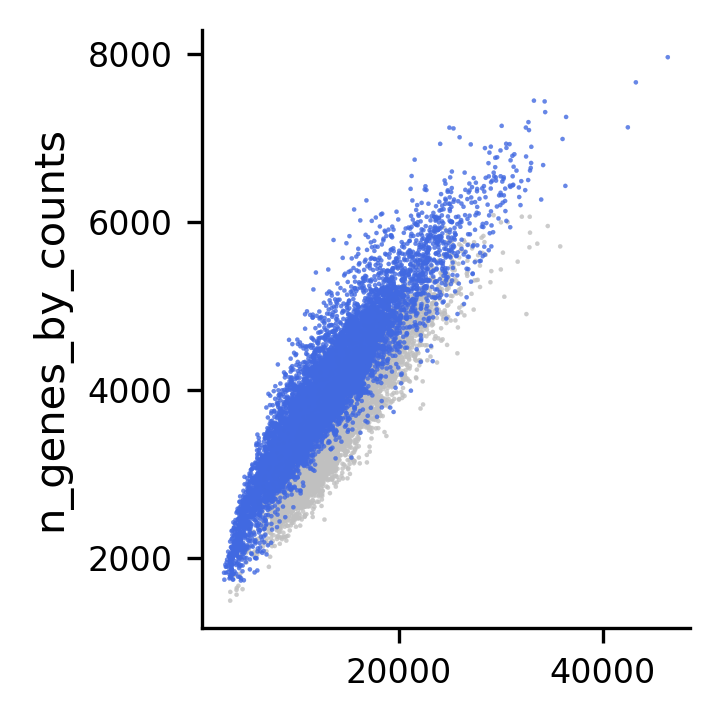

In [34]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 2.5

df = adata.obs[['total_counts', 'n_genes_by_counts', 'dataset']].copy()
df = df.sort_values(by='dataset', ascending=False)

colors = ["silver", "royalblue"]

sns.scatterplot(data=df,
                x='total_counts',
                y='n_genes_by_counts',
                hue='dataset',
                hue_order=['Control', 'Hybrid'],
                s=1,
                edgecolor=None,
                alpha=0.8,
                palette=colors,
                legend=False
               )

# sns.move_legend(plt.gca(), loc='lower right', fontsize='small', markerscale=3, title="")#, bbox_to_anchor=(1.1, 1))

# plt.ylabel("Genes per Cell")
plt.xlabel("")
# plt.xlabel("Reads per Cell")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.yscale('log')
# plt.xscale('log')

sns.despine()
plt.tight_layout()
plt.show()

In [35]:
corr, pval = pearsonr(adata.obs['total_counts'], adata.obs['n_genes_by_counts'])

print(f"\nPearson Correlation (total_counts vs. n_genes_by_counts): {corr:.4f}")
print(f"P-value: {pval:.4e}")


corr, pval = pearsonr(adata.obs['total_counts'], adata.obs['pct_counts_mt'])

print(f"\nPearson Correlation (total_counts vs. pct_counts_mt): {corr:.4f}")
print(f"P-value: {pval:.4e}")


Pearson Correlation (total_counts vs. n_genes_by_counts): 0.8652
P-value: 0.0000e+00

Pearson Correlation (total_counts vs. pct_counts_mt): -0.3357
P-value: 0.0000e+00


In [36]:
corr_df = adata.obs[['dataset', 'total_counts', 'n_genes_by_counts']].copy()

corr_by_dataset = corr_df.groupby('dataset', observed=True).corr()
corr_by_dataset

total_counts  n_genes_by_counts
dataset                                                   
Hybrid  total_counts           1.000000           0.924146
        n_genes_by_counts      0.924146           1.000000
Control total_counts           1.000000           0.919580
        n_genes_by_counts      0.919580           1.000000

computing neighbors
    finished (0:00:02)
computing tSNE
    using sklearn.manifold.TSNE
    finished (0:03:13)
running Leiden clustering
    finished (0:00:00)


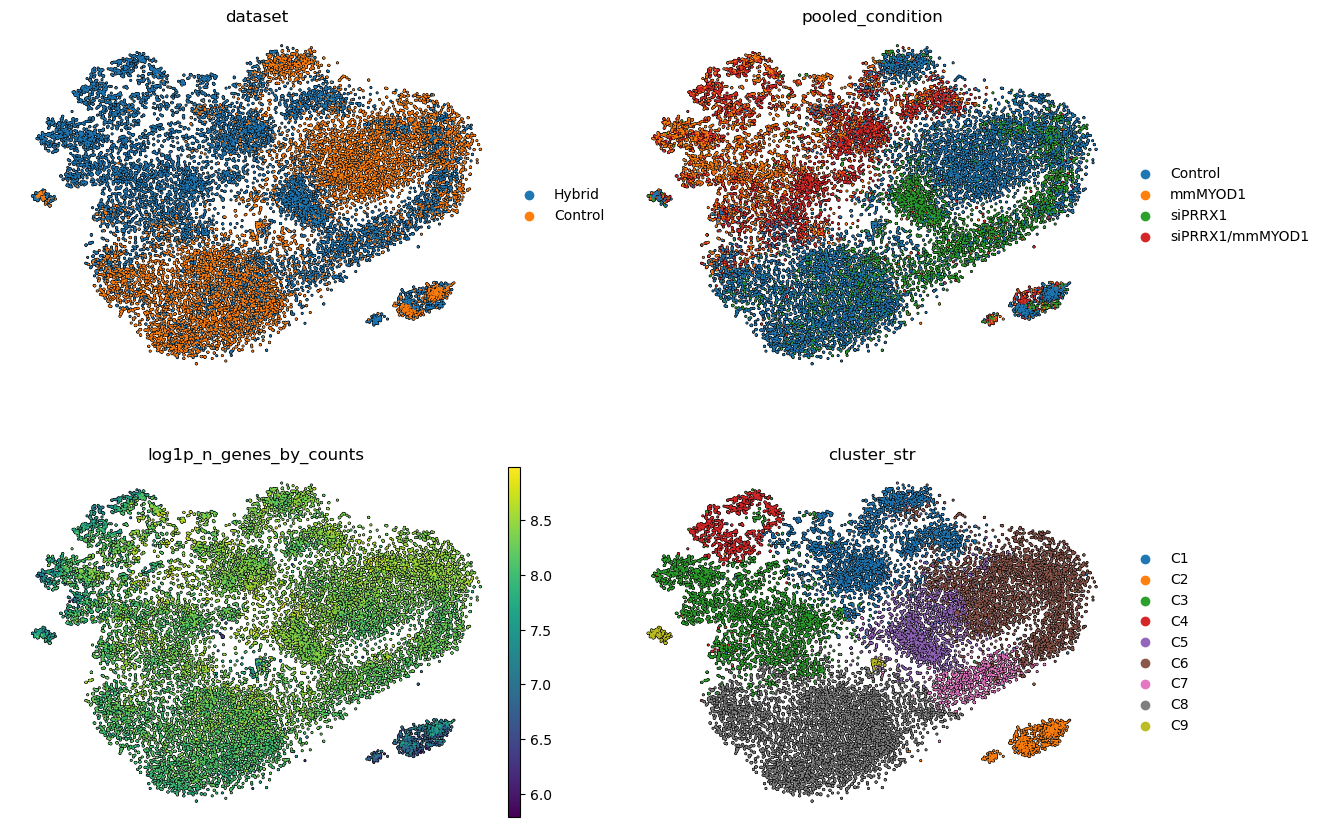

In [186]:
# sc.pp.neighbors(
#     adata,
#     use_rep='X_pca_harmony',
#     n_neighbors=10,
# )

# sc.tl.tsne(
#     adata,
#     use_rep='X_pca_harmony',

# )

# sc.tl.leiden(
#     adata,
#     resolution=0.5,
#     flavor="igraph",
#     n_iterations=-1, 
# )

# adata.obs['cluster_str'] = adata.obs['leiden'].apply(lambda x: f"C{str(int(x) + 1)}")

# sc.pl.tsne(
#     adata,
#     color=['dataset', 'pooled_condition', 'log1p_n_genes_by_counts', 'cluster_str'],
#     ncols=2,
#     add_outline=True,
#     outline_color=('k', 'k'),
#     frameon=False,
#     alpha=1,
# )

# UMAP

computing neighbors
    finished (0:00:02)
computing UMAP
    finished (0:00:12)
running Leiden clustering
    finished (0:00:00)


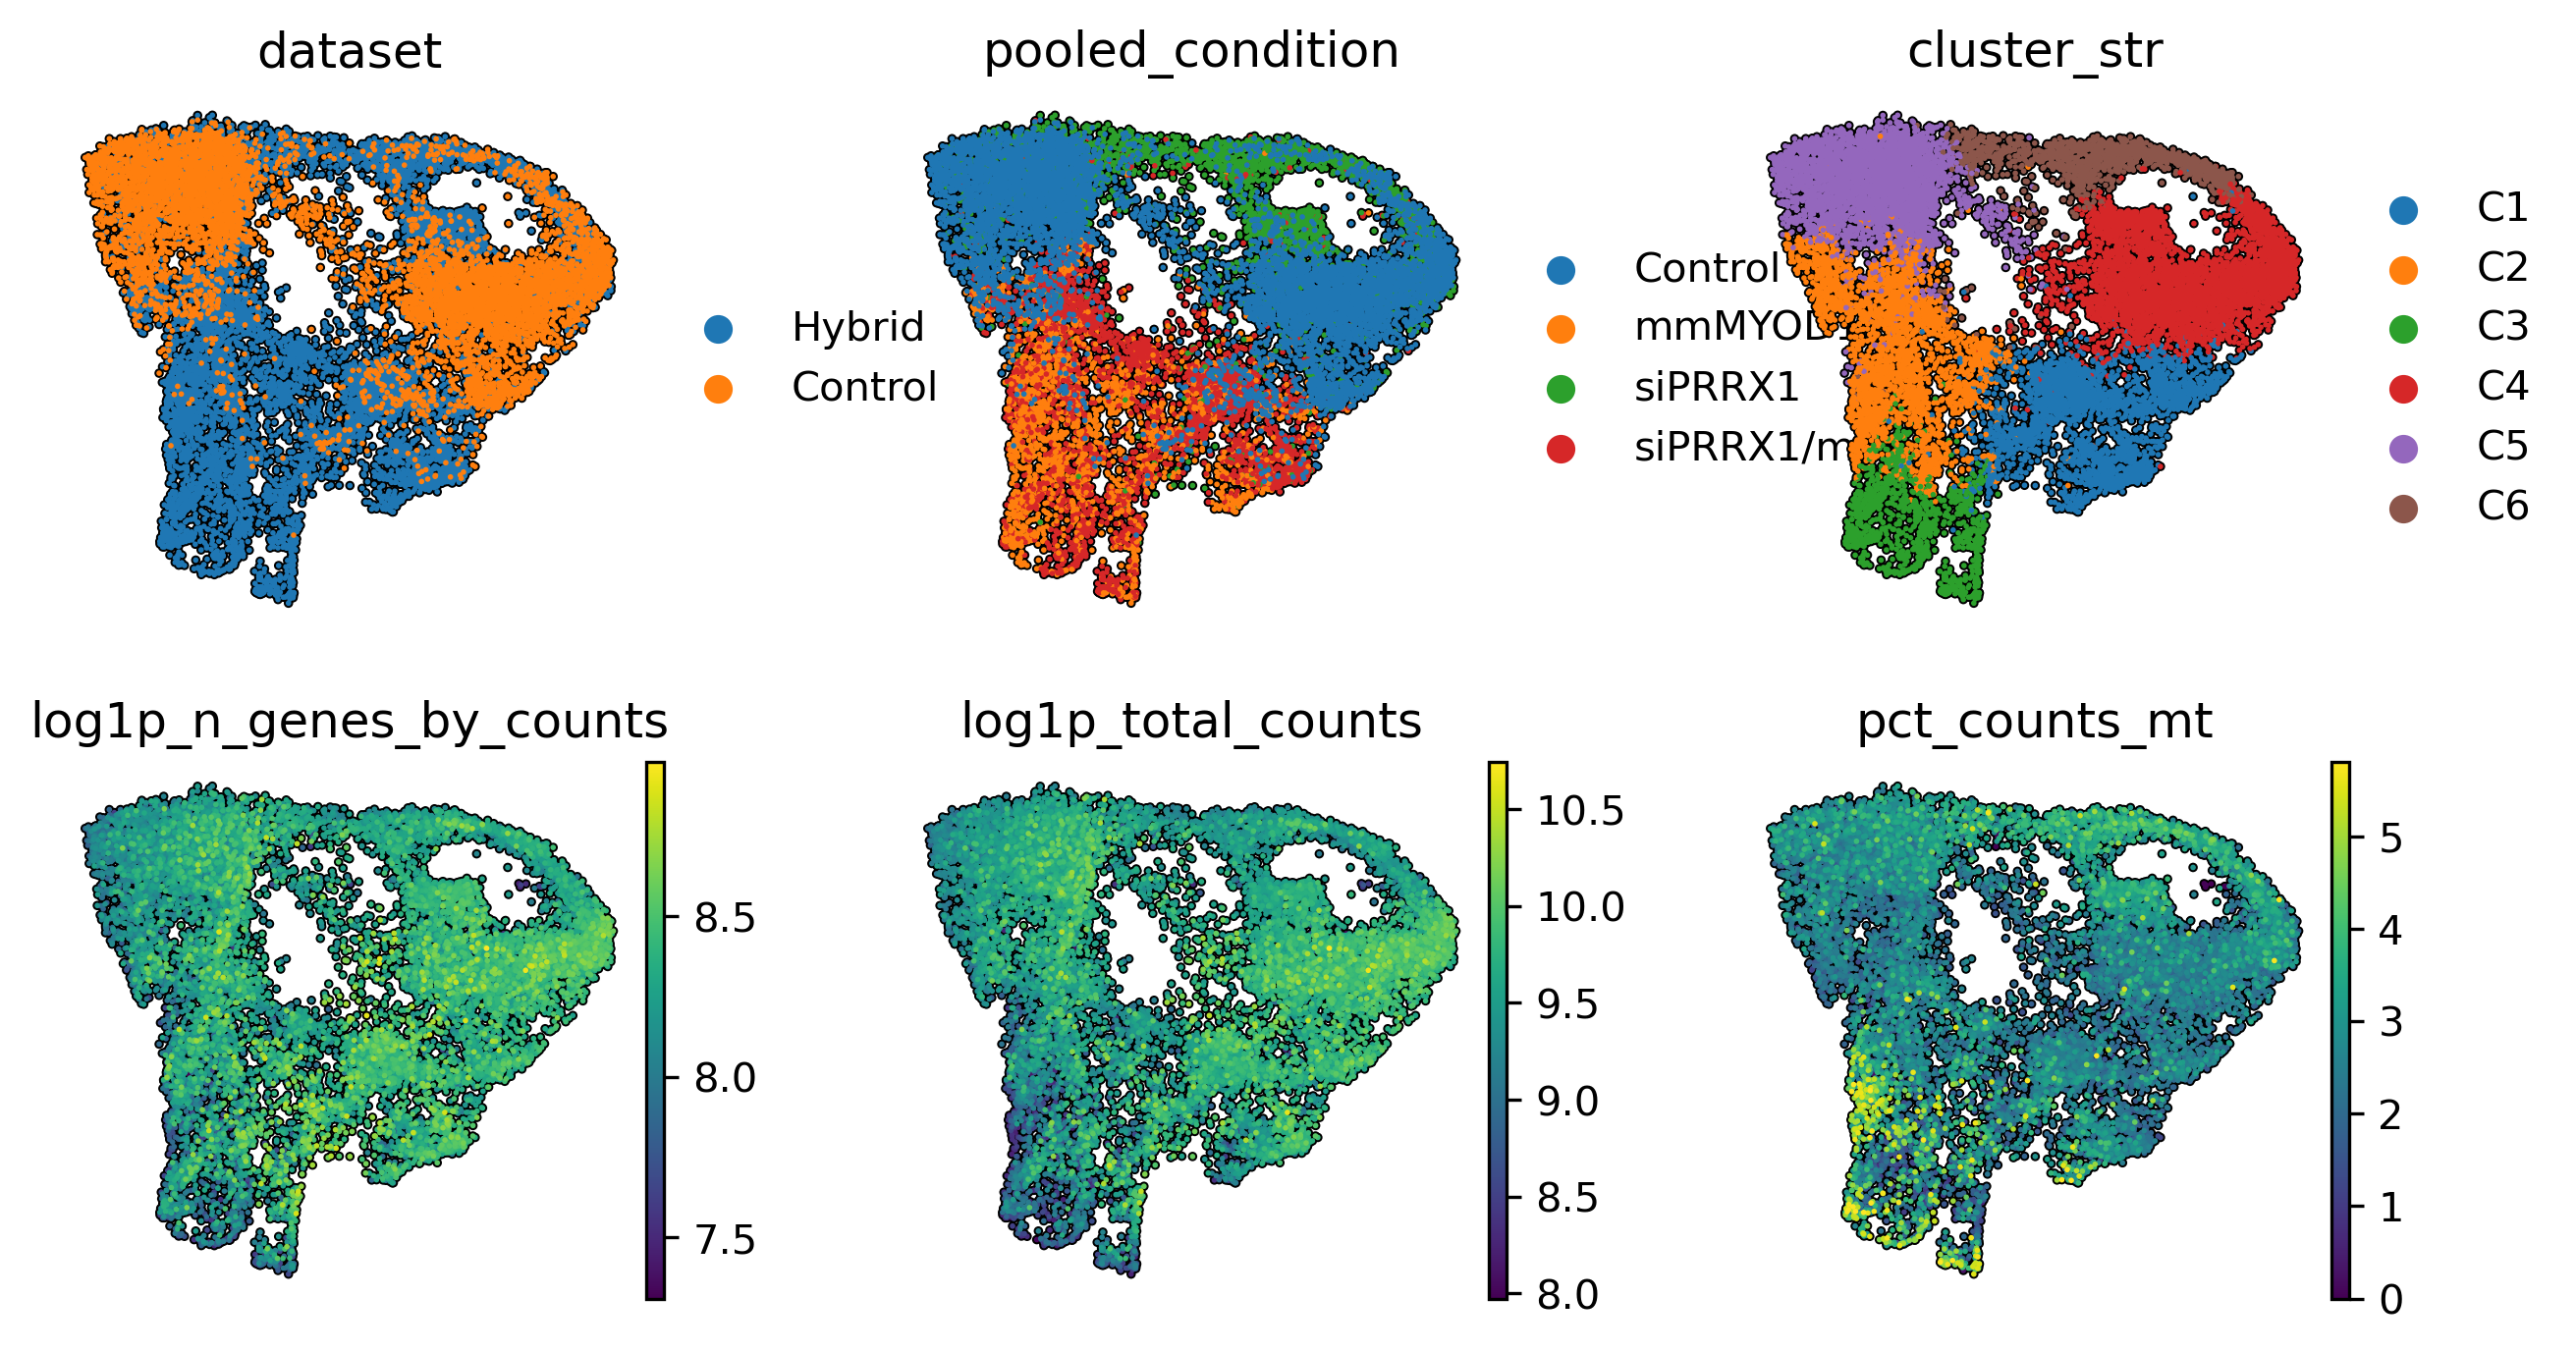

In [37]:
sc.pp.neighbors(
    adata,
    use_rep='X_pca_harmony',
    n_neighbors=10,
)

sc.tl.umap(
    adata,
    min_dist=0.2
)

sc.tl.leiden(
    adata,
    resolution=0.4,
    flavor="igraph",
    n_iterations=-1, 
)

adata.obs['cluster_str'] = adata.obs['leiden'].apply(lambda x: f"C{str(int(x) + 1)}")

sc.pl.umap(
    adata,
    color=['dataset', 'pooled_condition', 'cluster_str', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt'],
    ncols=3,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

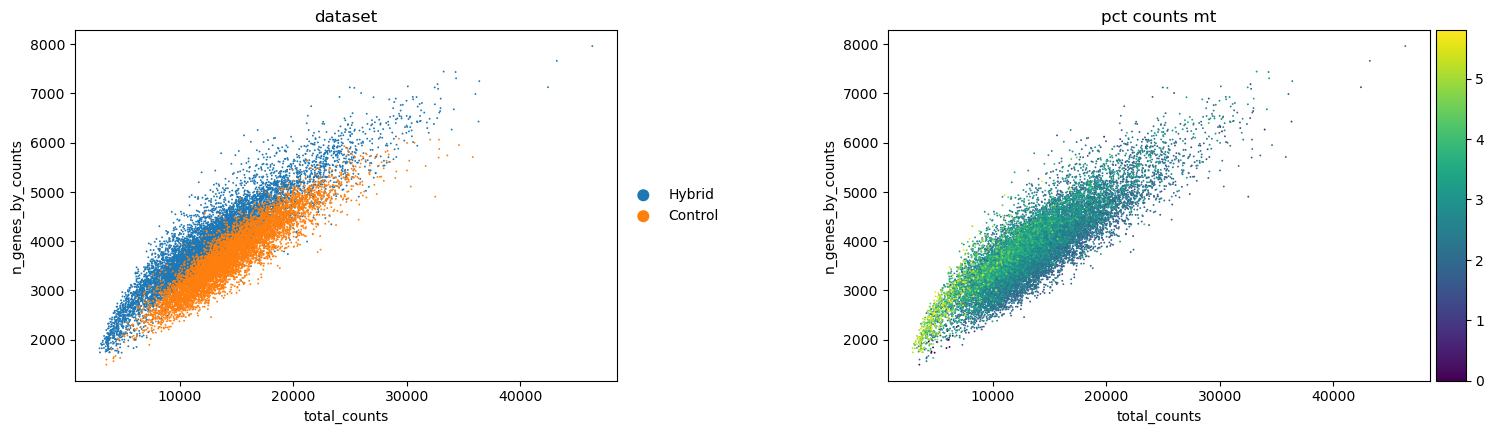

In [39]:
plt.rcdefaults()
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color=["dataset", "pct_counts_mt"])

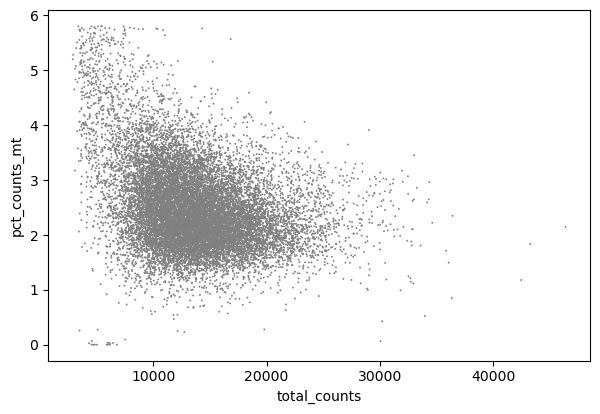

In [40]:
sc.pl.scatter(adata, 'total_counts', 'pct_counts_mt')

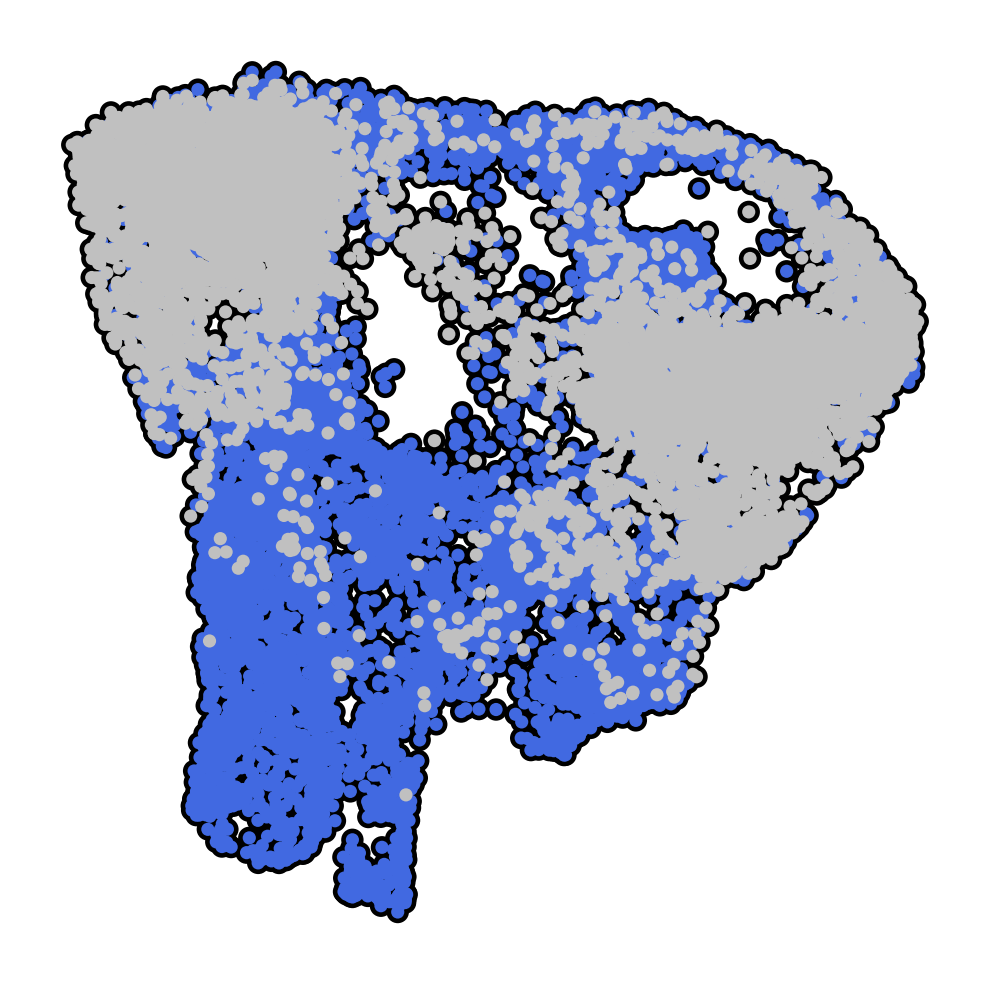

In [41]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

dataset_colors = ["royalblue", "silver"]

sc.pl.umap(
    adata,
    color='dataset',
    size=40,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False, 
    alpha=1,
    title="",
    palette=dataset_colors,
    legend_loc='none',
)

In [42]:
adata

AnnData object with n_obs × n_vars = 16367 × 25126
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'leiden', 'cluster_str'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_i

# Score cell cycle genes

S phase genes: 43
G2M phase genes: 54
calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01)
computing score 'G2M_score'
    finished (0:00:01)


... storing 'phase' as categorical


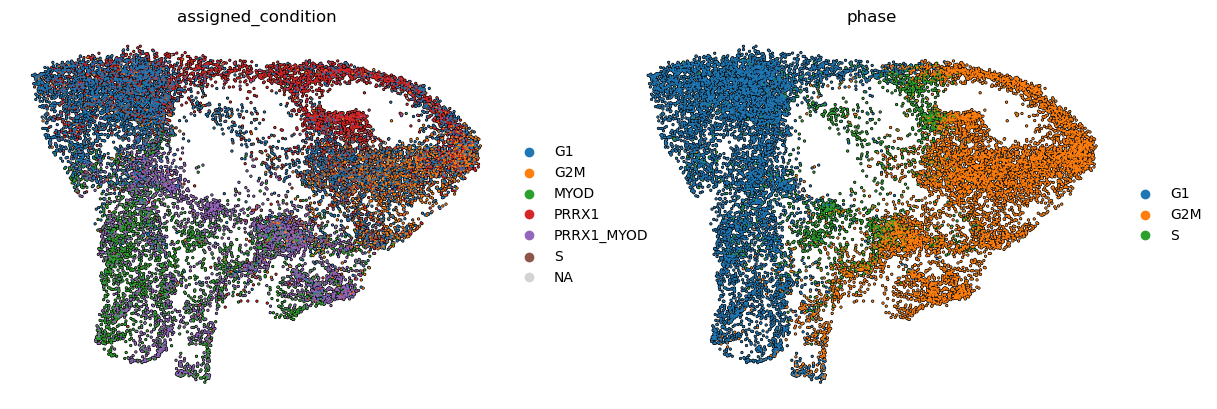

AnnData object with n_obs × n_vars = 16367 × 25126
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'leiden', 'cluster_str', 'S_score', 'G2M_score', 'phase'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_varia

In [43]:
path = "/nfs/turbo/umms-indikar/Ram/projects/reprogramming/Genexpression/Pseudotime/data/regev_lab_cell_cycle_genes.txt"

cell_cycle_genes = [x.strip() for x in open(path)]

s_genes = cell_cycle_genes[:43]
print(f"S phase genes: {len(s_genes)}")

g2m_genes = cell_cycle_genes[43:]
print(f"G2M phase genes: {len(g2m_genes)}")

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
)

plt.rcdefaults()

sc.pl.umap(
    adata,
    color=['assigned_condition', 'phase'],
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

adata

In [46]:
### --- Add filtering metadata to adata.uns ---
adata.uns['processing_parameters'] = {
    # 'max_pct_mito': 20,
    # 'min_counts_per_cell': 500,
    'Cell filtering': 'Low quality (outlier) cells were identified via median absolute deviation (MAD) filtering on log1p_total_counts, log1p_n_genes_by_counts, and pct_counts_mt per dataset. A MAD threshold of 5 was used.',
    'min_counts_per_gene': 10,
    'Normalization': 'Raw counts were normalized to 10,000 per cell and log-transformed.',
    'HVGs': 'Default flavor. 2,000 total HVGs selected with batch_key = dataset.',
    'Integration': 'Datasets integrated using Harmony with default parameters.',
    'UMAP': 'Neighbors selected using Harmony-corrected PCA (n=10). min_dist = 0.2. Leiden resolution = 0.4.',
    'Cell cycle phases': 'Cell cycle phases were predicted using the Regev Lab genes.',
}

adata.uns['processing_parameters']

{'Cell filtering': 'Low quality (outlier) cells were identified via median absolute deviation (MAD) filtering on log1p_total_counts, log1p_n_genes_by_counts, and pct_counts_mt per dataset. A MAD threshold of 5 was used.',
 'min_counts_per_gene': 10,
 'Normalization': 'Raw counts were normalized to 10,000 per cell and log-transformed.',
 'HVGs': 'Default flavor. 2,000 total HVGs selected with batch_key = dataset.',
 'Integration': 'Datasets integrated using Harmony with default parameters.',
 'UMAP': 'Neighbors selected using Harmony-corrected PCA (n=10). min_dist = 0.2. Leiden resolution = 0.4.',
 'Cell cycle phases': 'Cell cycle phases were predicted using the Regev Lab genes.'}

In [47]:
adata.write_h5ad("/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_merged_gene_data.h5ad")
adata

AnnData object with n_obs × n_vars = 16367 × 25126
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'leiden', 'cluster_str', 'S_score', 'G2M_score', 'phase'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_varia